# `005` Multi-Layer Perceptron (MLP)

Requirements: 003 Backpropagation, 004 Tensors.

The Multi-Layer Perceptron (MLP) is one of the basic neural network structures that was invented in the eighties. It's a bio-inspired structure that emulates a neuron. In a very simplified way, a neuron is a cell that has many legs called dendrites, which receive signals from other neurons or external sources. Once this signals are received, they are combined (summed) in the cell, and if they surpass a certain threshold (activation function) the cell will pass the electrical impulse through some long fibers called axons to other cells.

The key to the network optimization lives in two places:
* The dendrites, which attenuate the impulses by a certain amount. This is modelled simply as multiplying each input to a neuron by a learnable weight. Hence, if we have 4 inputs cells and 8 output cells, we'll have $4\times8$ learnable weights connecting them, that can be stored into a `W`eight matrix.
* The cell threshold, that makes the cell less or more sensitive to impulses. This is modelled as adding one learnable number to the output of each cell. Typically, you'd consider a cell with an output value higher than 0 as activated, and lower than 0 as not activated. This means that for 8 cells, we'll have a matrix of $8$ thresholds, typically called `b`iases.

During the learning process of a artificial neural network, we use backpropagation to adjust the values of these weights and biases to try to minimize some loss function. The combination of a weight matrix and a bias matrix is called a layer. Typically, these are called **linear layers**.

In [1]:
import torch

def get_model():
	# input layer: 1 input is connected to 100 neurons
	W1 = torch.randn(1, 100) * .03  # these are the connection weights, initialized randomly
	b1 = torch.zeros(100)  # these are the connection biases, initially zero
	# hidden layer: 100 neurons are connected to another 100
	W2 = torch.randn(100, 100) * .03
	b2 = torch.zeros(100)
	# ouput layer: 100 neurons are connected to 1 output neuron
	W3 = torch.randn(100, 1) * .03
	b3 = torch.zeros(1)
	# make a list of parameter lists
	parameters = W1, b1, W2, b2, W3, b3
	for p in parameters: p.requires_grad = True  # tell pytorch we want to train these weights
	return parameters

print(f'Number of parameters in our network: {sum(p.numel() for p in get_model())}')

Number of parameters in our network: 10401


One thing you might note is that stacking two linear layers has the same expressive power as having a single one. Imagine your layers are just a number. If you have:

$$(input * W_1 + b_1) * W_2 + b_2 = input * W_1 * W_2 + b_1 * W_2 + b_2$$

And that is the same as having one single linear layer in which the first weight is $W_1 * W_2$ and a bias that is $b_1 * W_2 + b_2$. This is the reason why, for increasing the expressiveness of the network, you need to add non-linearities in between. That is, functions that can be represented as a linear function and hence add expressive power.

The most typical nonlinearity function applied is called rectifier linear unit (ReLU). It is defined as:

$$ReLU(x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{otherwise} \end{cases}$$

So basically, zeroing out the neuron if the output is less than zero. We'll use it in the forward pass.

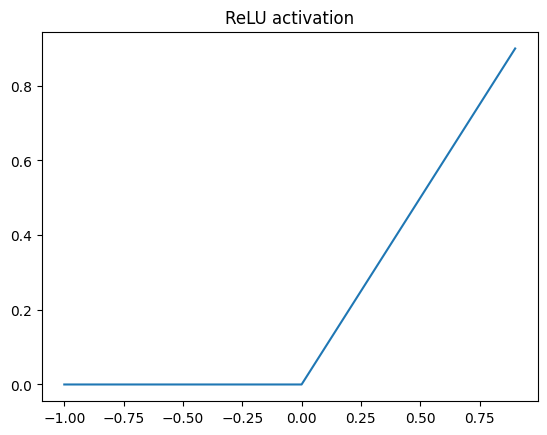

In [2]:
import torch
from matplotlib import pyplot as plt

X = torch.arange(-1, 1, .1)
plt.plot(X, X.relu())
plt.title('ReLU activation')

def forward(model, x):
	W1, b1, W2, b2, W3, b3 = model
	out = x @ W1 + b1
	out = out.relu()
	out = out @ W2 + b2
	out = out.relu()
	out = out @ W3 + b3
	return out

Let's define some arbitrary function we want to approximate and plot it.

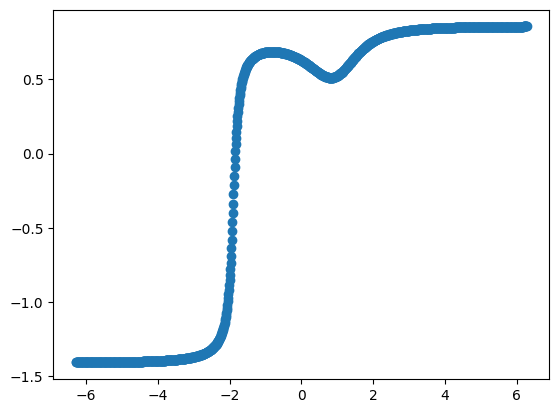

In [3]:
from math import pi
from matplotlib import pyplot as plt

f = lambda x: torch.atan(x**3 - 2*x + 3) - 5

X = torch.arange(-pi * 2, pi * 2, 0.01)  # create a set of points between (-2π, 2π) that are our inputs
X = X[torch.randperm(X.size(0))]  # shuffle it
X = X.view(-1, 1)
Y = f(X)
Y = (Y - Y.mean()) / Y.std()  # normalize the output to have mean 0 and std 1 (for better training)

plt.scatter(X, Y);

Now, let's train our model to approximate the function.

Final test loss is 0.005018338095396757


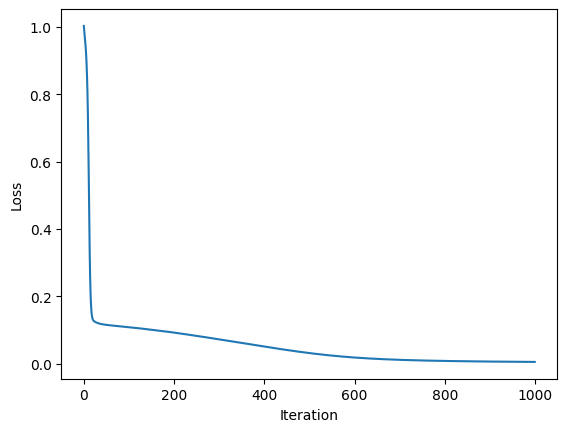

In [4]:
step_size = .1
model = get_model()
losses = []
for i in range(1000):
	Ypred = forward(model, X)
	loss = ((Ypred - Y)**2).mean()
	for p in model: p.grad = None
	loss.backward()
	for p in model: p.data -= p.grad * step_size
	# gather statistics
	losses.append(loss.item())

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
print(f'Final test loss is {loss}')

We can see how, after a few steps, our network stabilized. We have created an artifact that can approximate any given function if given the right set of weights, layers and size. This is why neural networks are called **universal approximators**.

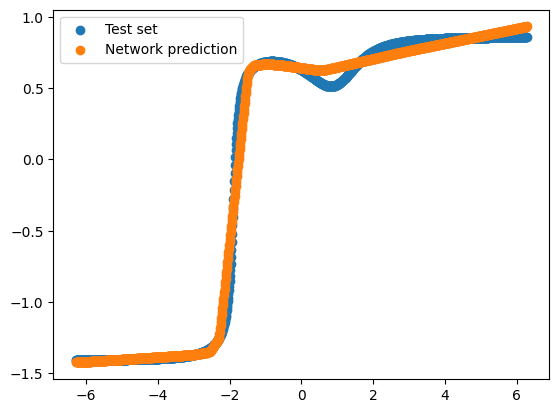

In [8]:
plt.scatter(X, Y, label='Test set')
plt.scatter(X, forward(model, X).detach().numpy(), label='Network prediction')
plt.legend();